<a href="https://colab.research.google.com/github/Data-Science-and-Data-Analytics-Courses/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit/blob/master/Week%2007%20Combining%20Simple%20Classifiers/DSE220x_PA7/DSE220x_PA7/kernel_SVM_and_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with kernel machines

In this notebook we will use simple two-dimensional data sets to illustrate the behavior of the support vector machine and the Perceptron, when used with quadratic and RBF kernels.

# Clone remote

In [0]:
import os, sys
from pathlib import Path

URL = "https://github.com/Data-Science-and-Data-Analytics-Courses/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit"
NBDIR = "Week 07 Combining Simple Classifiers/DSE220x_PA7/DSE220x_PA7"

def clone(url, dest=".", branch="master", reloc=True):
  """
  Clone remote branch from url into dest
  branch not provided: clone all branches
  reloc is True: relocate to repository
  """

  url = url.strip(" /")
  repo = Path(dest, os.path.basename(url)).resolve()

  # dest must not be inside existing repository
  is_out = !git -C "$dest" rev-parse
  if not is_out: # inside repository
    raise ValueError("Can't clone into existing repository")
  
  # Clone
  p = repo.as_posix()
  if branch: # specific branch
    !git clone --single-branch "$url" -b "$branch" "$p"
  else: # all branches
    !git clone "$url" "$p"
  
  # Relocate
  if reloc:
    %cd "$repo"

  return repo.as_posix()

REPO = clone(URL)
%run .Importable.ipynb
sys.path.append(REPO)
%cd "$NBDIR"

Cloning into '/content/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit'...
remote: Enumerating objects: 145, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 1024 (delta 68), reused 13 (delta 1), pack-reused 879
Receiving objects: 100% (1024/1024), 3.54 MiB | 7.69 MiB/s, done.
Resolving deltas: 100% (517/517), done.
/content/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit


/content/UCSanDiegoX---Machine-Learning-Fundamentals-03-Jan-2019-audit/Week 07 Combining Simple Classifiers/DSE220x_PA7/DSE220x_PA7


## 1. Basic training procedure

In [0]:
%matplotlib inline
import numpy as np
from itertools import product
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

The directory containing this notebook should also contain two-dimensional data files, `data1.txt` through `data5.txt`. These files contain one data point per line, along with a label (either -1 or 1), like:
* `3 8 -1` (meaning that point `x=(3,8)` has label `y=-1`)

The next procedure, **learn_and_display_SVM**, loads one of these data sets, invokes `sklearn.SVC` to learn a classifier, and then displays the data as well as the boundary. It is invoked as follows:
* `learn_and_display_SVM(datafile, kernel_type, C_value, s_value)`

where
* `datafile` is one of `'data1.txt'` through `'data5.txt'` (or another file in the same format)
* `kernel_type` is either `'quadratic'` or `'rbf'`
* `C_value` is the setting of the soft-margin parameter `C` (default: 1.0)
* `s_value` (for the RBF kernel) is the scaling parameter `s` (default: 1.0)

In [0]:
def learn_and_display_SVM(datafile, kernel_type='rbf', C_value=1.0, s_value=1.0):
    data = np.loadtxt(datafile)
    n,d = data.shape
    # Create training set x and labels y
    x = data[:,0:2]
    y = data[:,2]
    # Now train a support vector machine and identify the support vectors
    if kernel_type == 'rbf':
        clf = SVC(kernel='rbf', C=C_value, gamma=1.0/(s_value*s_value))
    if kernel_type == 'quadratic':
        clf = SVC(kernel='poly', degree=2, C=C_value, coef0=1.0)
    clf.fit(x,y)
    sv = np.zeros(n,dtype=bool)
    sv[clf.support_] = True
    notsv = np.logical_not(sv)
    # Determine the x1- and x2- limits of the plot
    x1min = min(x[:,0]) - 1
    x1max = max(x[:,0]) + 1
    x2min = min(x[:,1]) - 1
    x2max = max(x[:,1]) + 1
    plt.xlim(x1min,x1max)
    plt.ylim(x2min,x2max)
    # Plot the data points, enlarging those that are support vectors
    plt.plot(x[(y==1)*notsv,0], x[(y==1)*notsv,1], 'ro')
    plt.plot(x[(y==1)*sv,0], x[(y==1)*sv,1], 'ro', markersize=10)
    plt.plot(x[(y==-1)*notsv,0], x[(y==-1)*notsv,1], 'k^')
    plt.plot(x[(y==-1)*sv,0], x[(y==-1)*sv,1], 'k^', markersize=10)
    # Construct a grid of points and evaluate classifier at each grid points
    grid_spacing = 0.05
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, grid_spacing), np.arange(x2min, x2max, grid_spacing))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    Z = clf.decision_function(grid)
    # Quantize the values to -1, -0.5, 0, 0.5, 1 for display purposes
    for i in range(len(Z)):
        Z[i] = min(Z[i],1.0)
        Z[i] = max(Z[i],-1.0)
        if (Z[i] > 0.0) and (Z[i] < 1.0):
            Z[i] = 0.5
        if (Z[i] < 0.0) and (Z[i] > -1.0):
            Z[i] = -0.5
    # Show boundary and margin using a color plot
    Z = Z.reshape(xx1.shape)
    plt.pcolormesh(xx1, xx2, Z, cmap=plt.cm.PRGn, vmin=-2, vmax=2)
    plt.show()

## 2. Experiments with the quadratic kernel

Let's try out SVM on some examples, starting with the quadratic kernel.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


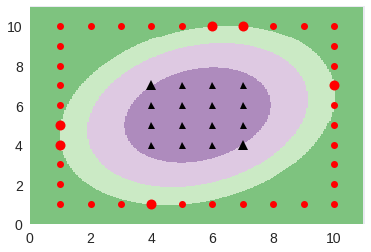

In [0]:
learn_and_display_SVM('data1.txt', 'quadratic', 1.0)

Also try `data2.txt` through `data5.txt`. Also try changing the value of `C` (the third parameter) to see how that affects the boundary and margin.

data1.txt 1.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


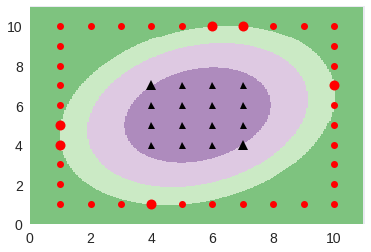

data1.txt 10.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


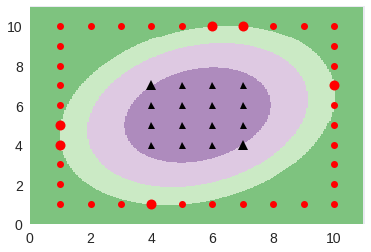

data1.txt 100.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


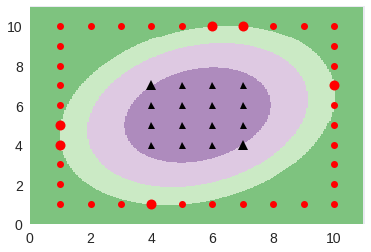

data2.txt 1.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


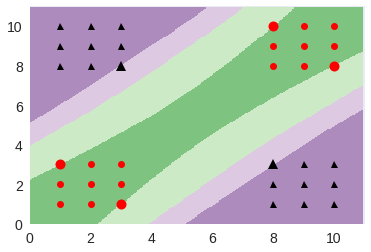

data2.txt 10.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


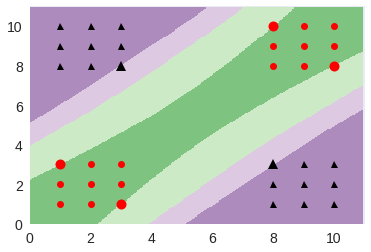

data2.txt 100.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


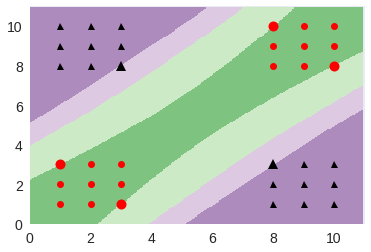

data3.txt 1.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


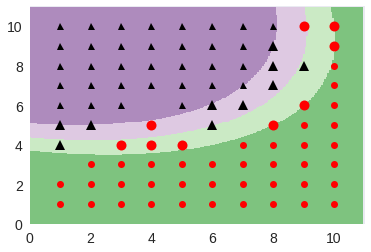

data3.txt 10.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


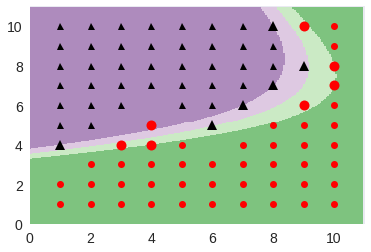

data3.txt 100.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


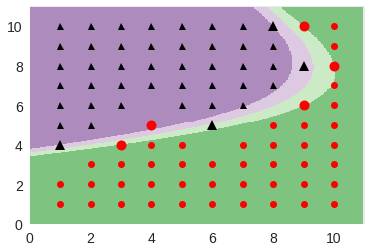

data4.txt 1.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


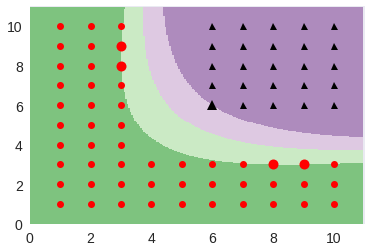

data4.txt 10.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


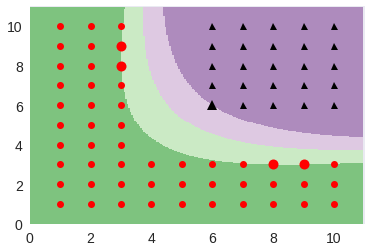

data4.txt 100.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


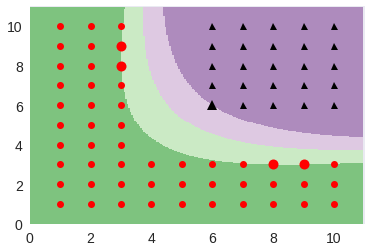

data5.txt 1.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


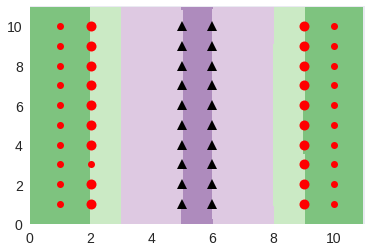

data5.txt 10.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


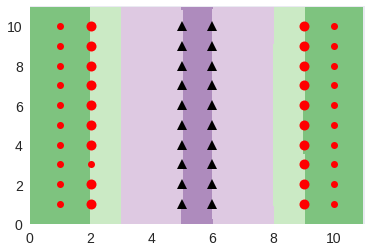

data5.txt 100.0


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


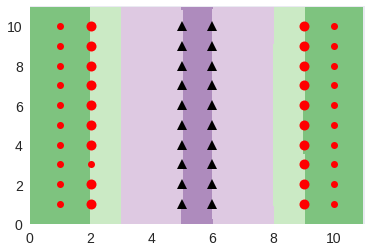

In [0]:
Cs = [1.0, 10.0, 100.0]
datafiles = ["data1.txt", "data2.txt", "data3.txt", "data4.txt", "data5.txt"]
for f, c in product(datafiles, Cs):
  print(f, c)
  learn_and_display_SVM(f, 'quadratic', c)

## 3. Experiments with the RBF kernel

Now experiment with the RBF kernel, on the same five data sets. This time there are two parameters to play with: `C` and `sigma`.

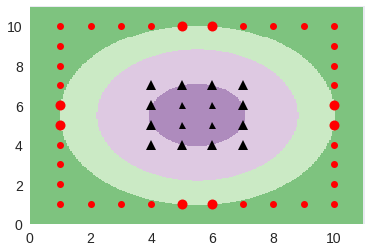

In [0]:
learn_and_display_SVM('data1.txt', 'rbf', 10.0, 10.0)

data1.txt 1.0 1.0


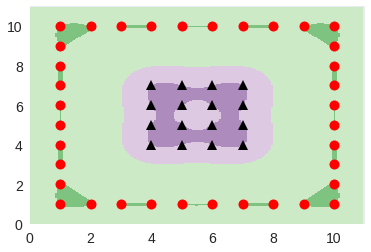

data1.txt 1.0 10.0


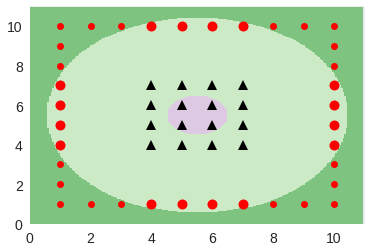

data1.txt 1.0 100.0


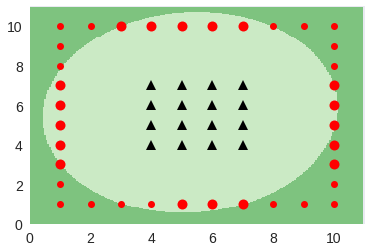

data1.txt 10.0 1.0


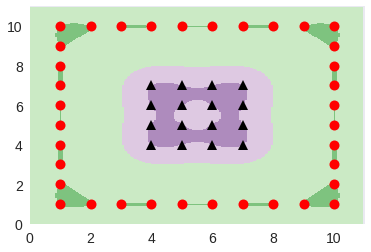

data1.txt 10.0 10.0


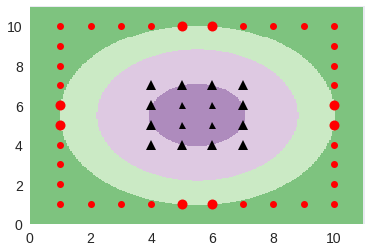

data1.txt 10.0 100.0


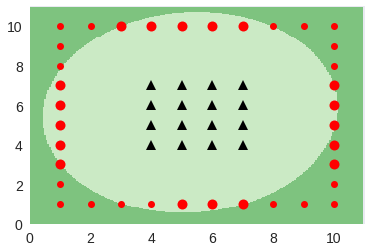

data1.txt 100.0 1.0


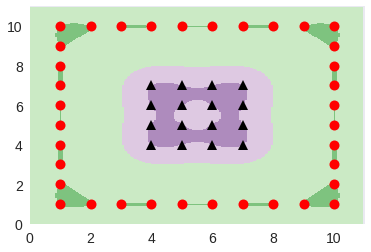

data1.txt 100.0 10.0


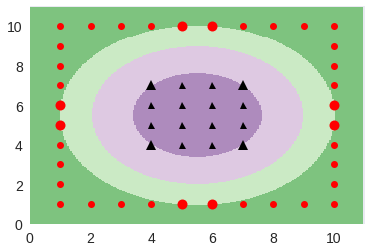

data1.txt 100.0 100.0


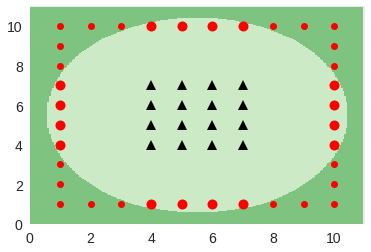

data2.txt 1.0 1.0


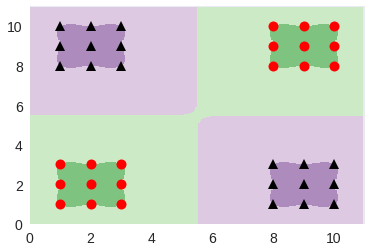

data2.txt 1.0 10.0


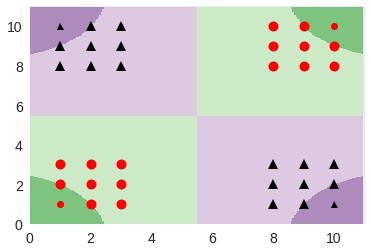

data2.txt 1.0 100.0


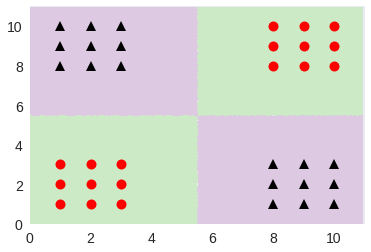

data2.txt 10.0 1.0


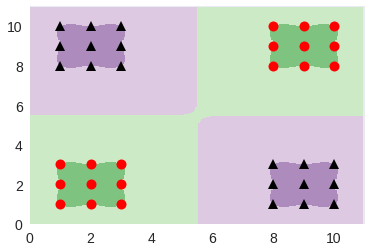

data2.txt 10.0 10.0


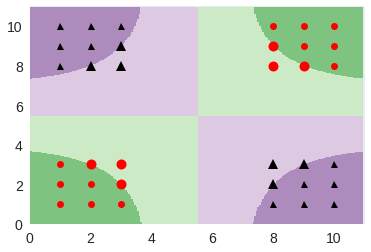

data2.txt 10.0 100.0


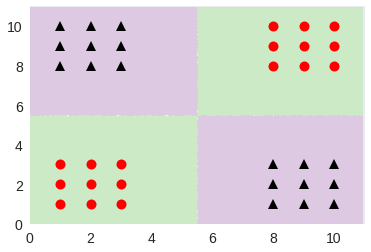

data2.txt 100.0 1.0


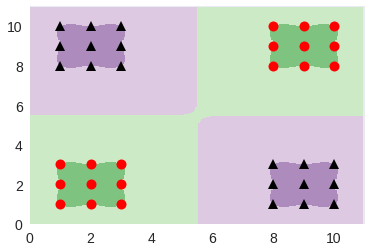

data2.txt 100.0 10.0


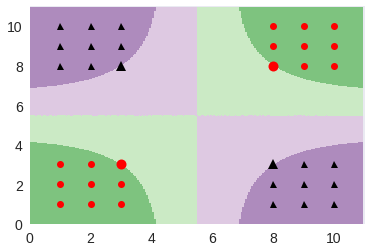

data2.txt 100.0 100.0


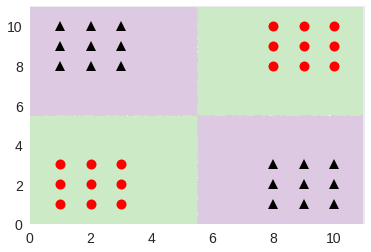

data3.txt 1.0 1.0


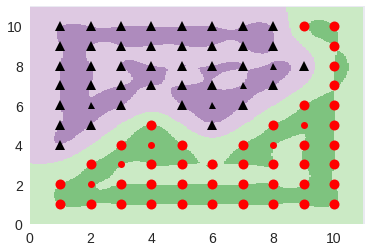

data3.txt 1.0 10.0


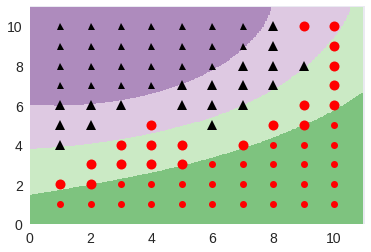

data3.txt 1.0 100.0


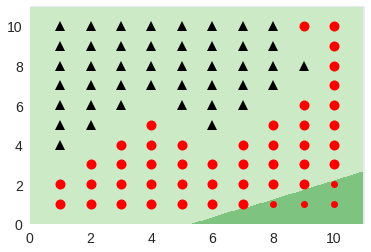

data3.txt 10.0 1.0


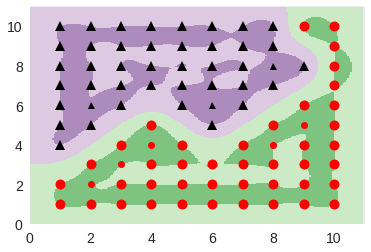

data3.txt 10.0 10.0


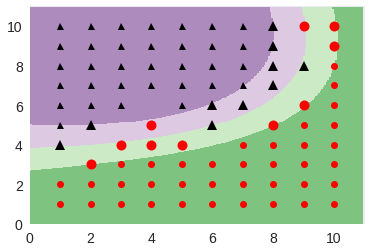

data3.txt 10.0 100.0


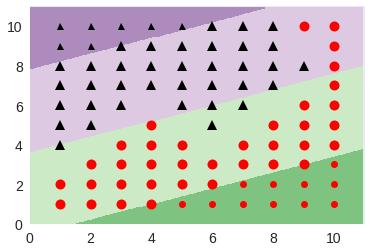

data3.txt 100.0 1.0


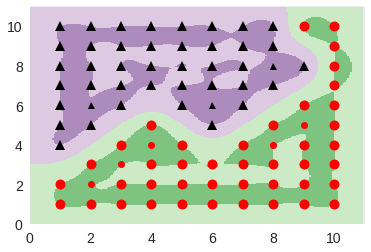

data3.txt 100.0 10.0


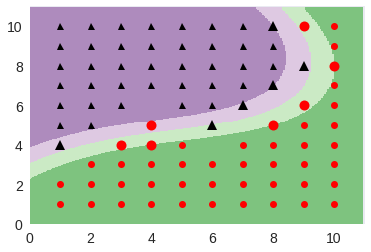

data3.txt 100.0 100.0


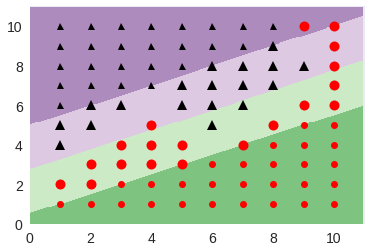

data4.txt 1.0 1.0


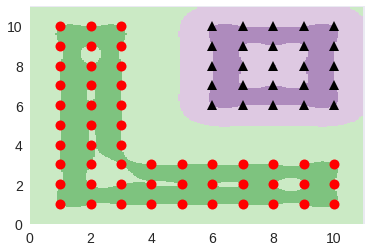

data4.txt 1.0 10.0


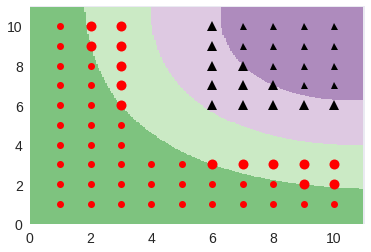

data4.txt 1.0 100.0


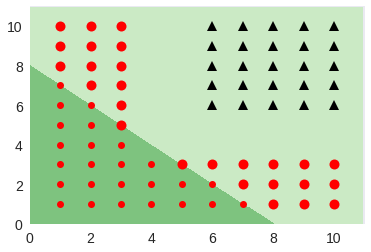

data4.txt 10.0 1.0


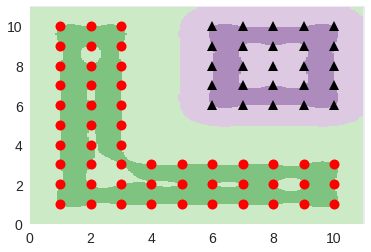

data4.txt 10.0 10.0


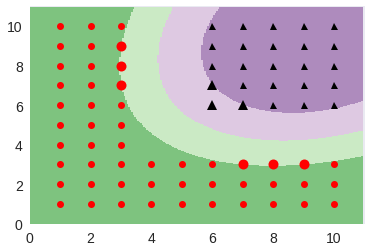

data4.txt 10.0 100.0


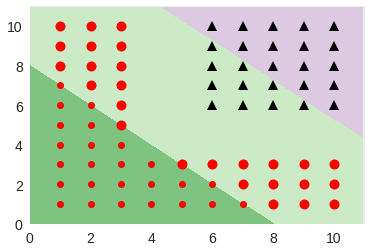

data4.txt 100.0 1.0


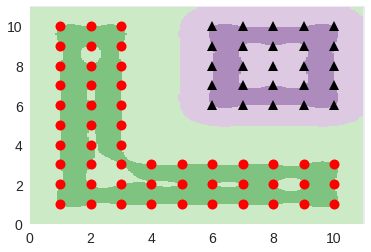

data4.txt 100.0 10.0


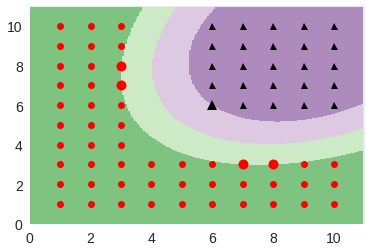

data4.txt 100.0 100.0


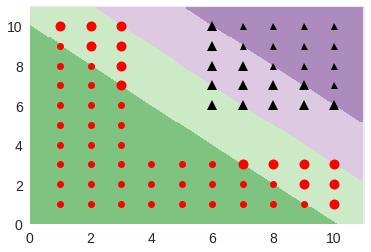

data5.txt 1.0 1.0


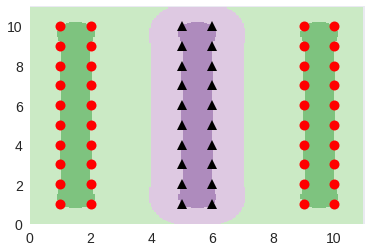

data5.txt 1.0 10.0


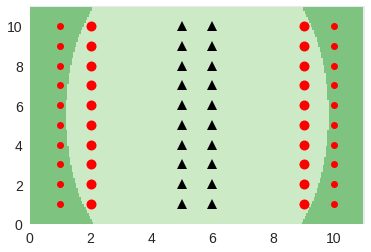

data5.txt 1.0 100.0


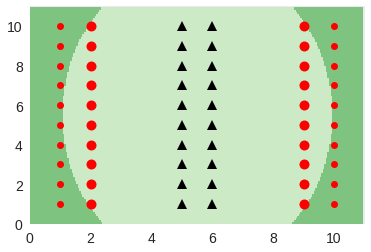

data5.txt 10.0 1.0


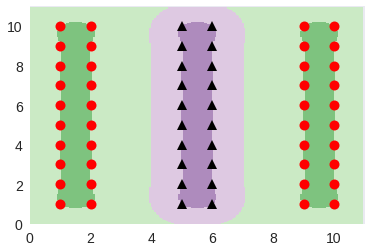

data5.txt 10.0 10.0


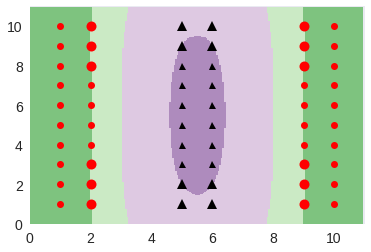

data5.txt 10.0 100.0


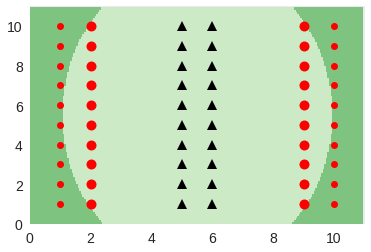

data5.txt 100.0 1.0


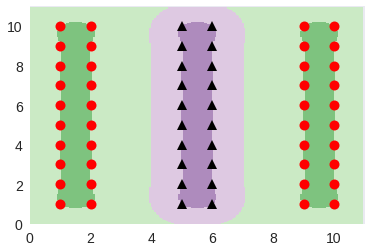

data5.txt 100.0 10.0


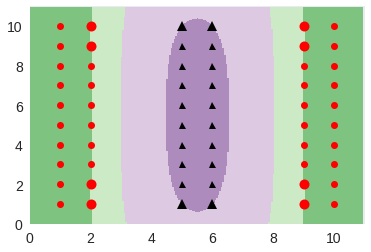

data5.txt 100.0 100.0


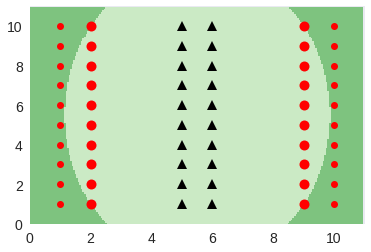

In [0]:
datafiles = ["data1.txt", "data2.txt", "data3.txt", "data4.txt", "data5.txt"]
Cs= [1.0, 10.0, 100.0]
sigmas = [1.0, 10.0, 100.0]
for f, c, s in product(datafiles, Cs, sigmas):
  print(f, c, s)
  learn_and_display_SVM(f, 'rbf', c, s)


## 4. The kernel Perceptron

<font color="magenta">**For you to do:**</font> Implement the kernel Perceptron algorithm as specified in lecture. Your algorithm should allow both the quadratic and RBF kernel, and should follow roughly the same signature as the SVM routine above:
* `learn_and_display_Perceptron(datafile, kernel_type, s_value)`

Recall that the Perceptron algorithm does not always converge; you will need to explicitly check for this.

In [0]:
def kernel_quad(x, z):
  # Compare z to x
  return (z.dot(x.T) + 1)**2

# def kernel_rbf(x, s):
#   xxT = x.dot(x.T)
#   diag = xxT.diagonal()
#   k = np.zeros(xxT.shape)
#   for i, j in np.ndindex(k.shape):
#     k[i, j] = np.exp(-(-2*xxT[i, j] + diag[i] + diag[j])/s**2)
#   return k

def kernel_rbf(x, z, s):
  # Compare z to x
  zxT = z.dot(x.T)
  diag = np.diag(zxT.diagonal())
  ones = np.ones(zxT.shape)
  power = -(diag.dot(ones) -2*zxT + ones.dot(diag)) / s**2
  k = np.exp(power)
  return k
### 
### Any auxiliary functions that you need
###
def learn_and_display_Perceptron(datafile, kernel_type='rbf', s_value=1.0, iters=1000):
  ###
  ### Your code
  ###
  # Create training set x and labels y
  data = np.loadtxt(datafile)
  x = data[:,0:2]
  y = data[:,2]
  n,d = x.shape

  # Kernel
  if kernel_type == 'rbf':
    k = kernel_rbf(x, s_value)
  if kernel_type == 'quadratic':
    k = kernel_quad(x)

  # Common terms
  yk = y*k

  # Update
  alpha = np.zeros(n)
  b = 0
  for it in range(iters):
    converged = True
    for i in range(n):
      score = y[i] * (alpha.dot(yk[i]) + b)
      if score <= 0:
        alpha[i] += 1
        b += y[i]
        converged = False
    if converged:
      break
      
  return alpha, b, 

    

In [0]:
a=np.arange(6).reshape(3,2)
print(a)
b=np.array([2,3])
print(b)
a*b
len(range(10))

10

<font color="magenta">Experiment with your routine, on the same five data sets.</font>